# 3주차, Feature Engineering  

In [1]:
import pandas as pd 
import numpy as np
import os 
import geopandas as gpd
import sys
from shapely.geometry import *
from shapely.ops import *
from fiona.crs import from_string
epsg4326 = from_string("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
epsg5179 = from_string("+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs")

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = 'C:/Windows/Fonts/malgun.ttf').get_name()
matplotlib.rc('font', family = font_name)
import folium

In [2]:
os.chdir(r"D:\Python\kaggle\dacon_bus_inout\\")
print("path: "+ os.getcwd())
print(os.listdir())

path: D:\Python\kaggle\dacon_bus_inout
['.ipynb_checkpoints', 'bus_bts.csv', 'drive-download-20200214T141955Z-001.zip', 'LSMD_ADM_SECT_UMD_50.dbf', 'LSMD_ADM_SECT_UMD_50.prj', 'LSMD_ADM_SECT_UMD_50.shp', 'LSMD_ADM_SECT_UMD_50.shx', 'LSMD_ADM_SECT_UMD_제주', 'LSMD_ADM_SECT_UMD_제주.zip', 'submission_sample.csv', 'test.csv', 'train.csv', '~$행정_법정동 중심좌표.xlsx', '국토도시_윈터스쿨(중급반).ipynb', '행정_법정동 중심좌표.xlsx']


In [3]:
# dir_ = ""
train = pd.read_csv("train.csv", dtype=str, encoding='utf-8')
test = pd.read_csv("test.csv", dtype=str, encoding='utf-8')
bus_bts = pd.read_csv("bus_bts.csv", dtype=str, encoding='utf-8')
bjd_wgd = pd.read_excel("행정_법정동 중심좌표.xlsx", dtype= str, sheet_name="합본 DB")
sub = pd.read_csv("submission_sample.csv", dtype=str, encoding='utf-8')
print("train :", len(train))
print("test :", len(test))
print("bus_bts :", len(bus_bts))
print("submission_sample :", len(sub))

train : 415423
test : 228170
bus_bts : 2409414
submission_sample : 228170


In [4]:
col_t = [str(j)+"~"+ str(j+1) + "_" + str(i) for i in ("ride","takeoff") for j in range(6,12)]
train['date'] = pd.to_datetime(train['date'])
train[col_t + ['18~20_ride']] = train[col_t + ['18~20_ride']].astype(float)
test['date'] = pd.to_datetime(test['date'])
test[col_t] = test[col_t].astype(float)
bus_bts['geton_datetime'] = pd.to_datetime(bus_bts['geton_date'] + ' ' + bus_bts['geton_time'])
bus_bts['getoff_datetime'] = pd.to_datetime(bus_bts['getoff_date'] + ' ' + bus_bts['getoff_time'])
bus_bts['user_category'] = bus_bts['user_category'].astype(int)
bus_bts['user_count'] = bus_bts['user_count'].astype(float)

## 파생변수  

### 1. 시내, 시외 재구분  

In [97]:
st_col = ['station_code','station_name','in_out','longitude','latitude']
station_loc = pd.concat([train[st_col], test[st_col]], ignore_index=True).drop_duplicates().reset_index(drop=True)
station_loc[['longitude','latitude']] = station_loc[['longitude','latitude']].astype(float)
station_loc['geometry'] = station_loc.apply(lambda x : Point(x.longitude, x.latitude), axis=1)
station_loc = gpd.GeoDataFrame(station_loc, geometry='geometry', crs=epsg4326)
station_loc = station_loc.to_crs(epsg5179)
print("*버스 정류장 수 :", len(station_loc))
print(station_loc['in_out'].value_counts())
station_loc.head()

*버스 정류장 수 : 3601
시내    3519
시외      82
Name: in_out, dtype: int64


,station_code,station_name,in_out,longitude,latitude,geometry
0,344,제주썬호텔,시외,126.49373,33.48990,POINT (906519.4860620159 1500237.409276767)
1,357,한라병원,시외,126.48508,33.48944,POINT (905715.3864293153 1500194.228393832)
2,432,정존마을,시외,126.47352,33.48181,POINT (904633.0709735792 1499358.804023984)
3,1579,제주국제공항(600번),시내,126.49252,33.50577,POINT (906424.1528704709 1501998.097362769)
4,1646,중문관광단지입구,시내,126.41260,33.25579,POINT (898711.3044004028 1474356.529871264)


In [100]:
jeju_bjd = gpd.GeoDataFrame.from_file('LSMD_ADM_SECT_UMD_50.shp',encoding='cp949')
if jeju_bjd.crs is None:
    jeju_bjd.crs = epsg5179

In [104]:
jeju_main = jeju_bjd.explode().unary_union
jeju_main = jeju_main[np.argmax([i.area for i in jeju_main])].buffer(10).buffer(-10)
#gpd.GeoDataFrame({'geometry':[jeju_main]}, geometry='geometry', crs=epsg5179).to_file("test.shp")
station_loc['in_out_new'] = np.where(station_loc.within(jeju_main), 
                                     "in",
                                    "out")

In [107]:
station_loc['in_out_new'].value_counts()

in     3546
out      55
Name: in_out_new, dtype: int64

### 2. 요일 특성(요일별, 주말여부, 공휴일여부)    

In [110]:
def get_dayattr(df):
    # 0(Monday) ~ 6(Sunday)
    df['dayofweek'] = df['date'].dt.dayofweek
    # 추석, 한글날, 개천절
    holiday=['2019-09-12', '2019-09-13', '2019-09-14','2019-10-03','2019-10-09']
    df['weekends'] = np.where(df['dayofweek'] >= 5, 1,0) # 주말여부
    df['holiday'] = np.where(df['date'].isin(holiday), 1,0) # 공휴일여부
    return df
train = get_dayattr(train)

In [111]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,dayofweek,weekends,holiday
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1,0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508000000001,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,1,0
2,2,2019-09-01,4270000,시외,432,정존마을,33.481809999999996,126.47352,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,1,0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,1,0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.255790000000005,126.4126,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,1,0


### 3. 시간대 통합  

In [132]:
def merged_time_col(df, interval=2):
    global col_t
    df = df.copy()
    split_n= 6 / interval
    n1 = 0 
    for i in list(map(list,np.array_split(col_t[:6],split_n))):
        n1+=1
        df['ride_' + str(n1)] = train[i].sum(axis=1)
    n2 = 0
    for i in list(map(list,np.array_split(col_t[6:],split_n))):
        n2+=1
        df['takeoff_' + str(n2)] = train[i].sum(axis=1)    
    return df

In [133]:
train = merged_time_col(train, interval=2)
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,18~20_ride,dayofweek,weekends,holiday,ride_1,ride_2,ride_3,takeoff_1,takeoff_2,takeoff_3
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,0.0,1.0,...,0.0,6,1,0,1.0,7.0,8.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508000000001,1.0,4.0,...,5.0,6,1,0,5.0,6.0,11.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.481809999999996,126.47352,1.0,1.0,...,2.0,6,1,0,2.0,2.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,53.0,6,1,0,17.0,32.0,30.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.255790000000005,126.4126,0.0,0.0,...,0.0,6,1,0,0.0,0.0,0.0,0.0,1.0,0.0


### 4. 버스통행시간(travel time)    

In [134]:
delta_ = (bus_bts['getoff_datetime'] - bus_bts['geton_datetime'])
if delta_.dt.days.max() == 0:  
    bus_bts['travel_time'] = delta_.dt.seconds / 60 # minutes

In [136]:
bus_bts.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count,geton_datetime,getoff_datetime,travel_time
0,1010010127894129.0,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1.0,2019-09-10 06:34:45,2019-09-10 07:10:31,35.766667
1,1010010101730356.0,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1.0,2019-09-10 06:34:58,2019-09-10 06:56:27,21.483333
2,1019160032727943.0,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1.0,2019-09-10 07:19:07,2019-09-10 07:40:29,21.366667
3,1019150001770890.0,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1.0,2019-09-09 09:14:47,2019-09-09 10:02:46,47.983333
4,1010010097237127.0,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1.0,2019-09-09 09:28:53,2019-09-09 10:21:37,52.733333


In [139]:
bus_bts.groupby(['geton_date','bus_route_id','geton_station_name']).apply(lambda gr : gr['getoff_time'].isnull().sum())

geton_date  bus_route_id  geton_station_name
2019-09-01  17010000      제주웰컴센터                 5
            20010000      대서리사무소                 4
                          돈대산입구                  3
                          엘지마트                   2
                          여객선대합실                 8
                                                ..
2019-10-16  8180000       서귀포우체국서귀포시청제2청사        9
                          유승한내들아파트              16
                          정존마을                   4
                          회수마을회관                 6
            8880000       제주국제공항(600번)           6
Length: 477185, dtype: int64

In [163]:
test1 = test[test['bus_route_id']=='27780000'].\
            drop_duplicates(subset=['geton_station_code']).\
            sort_values(by='geton_datetime').\
            reset_index(drop=True)
test1

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count,geton_datetime,getoff_datetime,travel_time
0,5365100833079326.0,27780000,149796018,2019-09-26,07:09:44,3546,상명리동동,2019-09-26,07:24:49,2743.0,동광환승정류장2(영어교육도시방면),1,1.0,2019-09-26 07:09:44,2019-09-26 07:24:49,15.083333
1,1014140000140459.0,27780000,149796018,2019-09-26,07:15:47,938,금악초등학교,2019-09-26,07:24:20,2743.0,동광환승정류장2(영어교육도시방면),6,1.0,2019-09-26 07:15:47,2019-09-26 07:24:20,8.550000
2,1014140000079947.0,27780000,149796018,2019-09-26,11:40:51,1129,한림환승정류장(한림리),2019-09-26,12:05:16,938.0,금악초등학교,6,1.0,2019-09-26 11:40:51,2019-09-26 12:05:16,24.416667
3,1014140000179648.0,27780000,149796018,2019-09-26,11:46:47,822,동명리,2019-09-26,11:58:13,3519.0,명월상동,6,1.0,2019-09-26 11:46:47,2019-09-26 11:58:13,11.433333


### 5. 노선별, 정류소별 배차간격  

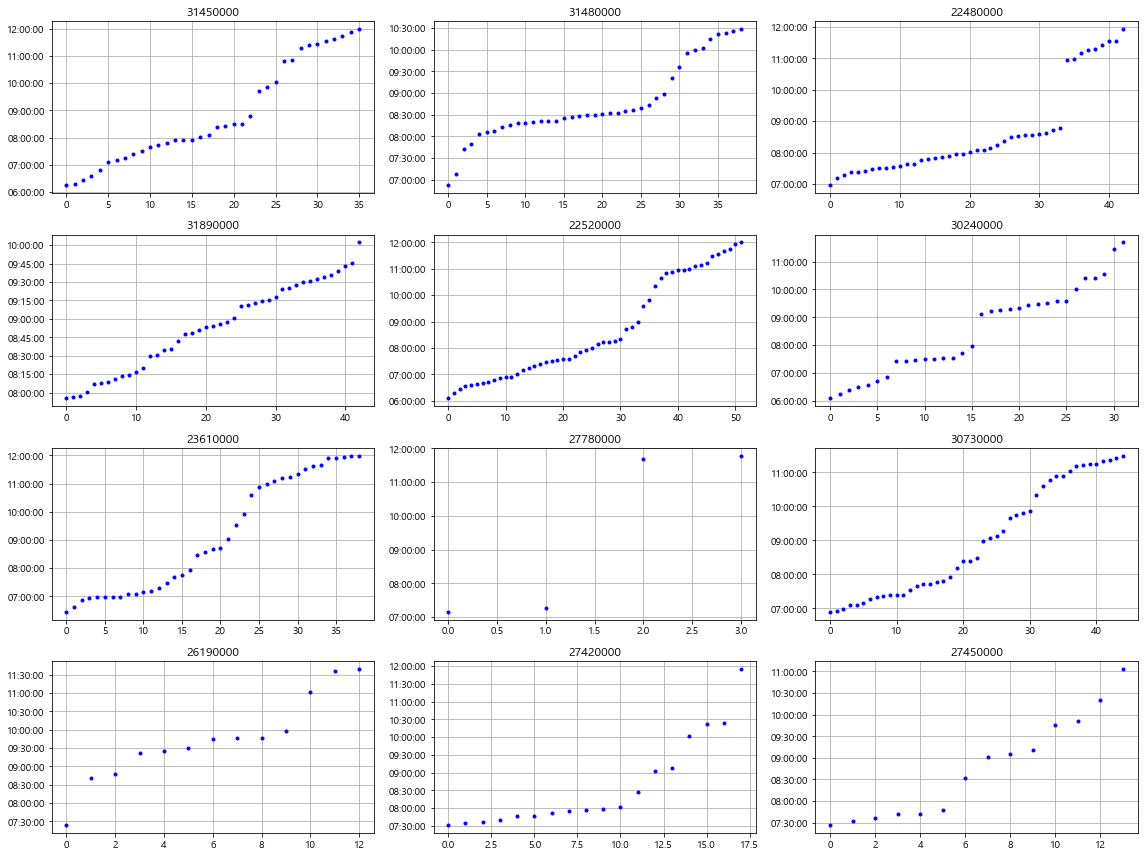

In [158]:
t_date = "2019-09-26"
test = bus_bts.copy()
test = test[(test['geton_date']==t_date)]
route_ls = test['bus_route_id'].unique().tolist()

import matplotlib.dates as mdates
plot_thresh_hold = 12
row_num = 4
col_num = plot_thresh_hold/row_num

i=0
plt.figure(figsize=(16,12))
for route in route_ls:
    i+=1
    test1 = test[test['bus_route_id']==route].\
                drop_duplicates(subset=['geton_station_code']).\
                sort_values(by='geton_datetime').\
                reset_index(drop=True)
    ax = plt.subplot(row_num,col_num,i)
    plt.title(route)
    ax.plot(range(len(test1)), test1['geton_datetime'], "b.")
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.grid()
    if i == plot_thresh_hold:
        plt.tight_layout()
        plt.show()
        break

### 6. 시간대별 승차 인원 (bus_bts)  

In [161]:
bus_bts['ride_slot'] = bus_bts['geton_datetime'].dt.hour.astype(str) + "~" + (bus_bts['geton_datetime'].dt.hour + 1).astype(str) + "_ride"
ride_slot_pv = pd.pivot_table(bus_bts,
                              index=['geton_date','bus_route_id', 'geton_station_code'],
                              columns='ride_slot',
                              values='user_count',
                              aggfunc=np.sum).reset_index().fillna(0)
ride_slot_pv = ride_slot_pv[['geton_date','bus_route_id','geton_station_code','6~7_ride','7~8_ride','8~9_ride','9~10_ride','10~11_ride','11~12_ride']]
ride_slot_pv['geton_date'] = pd.to_datetime(ride_slot_pv['geton_date'])
print(str(ride_slot_pv['geton_date'].min().date()) + " ~ " + str(ride_slot_pv['geton_date'].max().date()))
print("%s 건" % len(ride_slot_pv))
ride_slot_pv.head()

2019-09-01 ~ 2019-10-16
484386 건


ride_slot,geton_date,bus_route_id,geton_station_code,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride
0,2019-09-01,17010000,6000027,0.0,0.0,0.0,0.0,2.0,3.0
1,2019-09-01,20010000,6115000,0.0,2.0,1.0,2.0,6.0,0.0
2,2019-09-01,20010000,6115001,0.0,0.0,0.0,0.0,0.0,1.0
3,2019-09-01,20010000,6115002,0.0,0.0,1.0,4.0,0.0,0.0
4,2019-09-01,20010000,6115003,0.0,0.0,0.0,0.0,0.0,1.0


### 7. 통행목적의 분류(등교인지, 출근인지, 공항인지, 일반인지, 병원인지 등)  

### 8. 자주 환승하는 정류장 여부  

## 외부 데이터  